In [1]:
!pip install transformers[torch]

In [2]:
# Importing the pandas library for data manipulation and analysis
import pandas as pd

# Importing the JSON module for parsing JSON data
import json

def json_to_dataframe_from_file(file_path):
    """
    Convert JSON data from a file to a Pandas DataFrame.

    Args:
    - file_path (str): Path to the JSON file.

    Returns:
    - pd.DataFrame: A DataFrame containing the JSON data.
    """
    # Read the JSON data from the file
    with open(file_path, 'r') as file:
        json_data = json.load(file)

    # Initialize a list to store records
    records = []

    # Iterate over each item in the JSON data
    for item in json_data:
        context = item['context']  # Extract context from the item

        # Iterate over each QA pair in the current item
        for qa in item['qas']:
            question = qa['question']  # Extract question from the QA pair
            answer = qa['answer']      # Extract answer from the QA pair

            # Append a record to the list with context, question, and answer
            records.append({
                'context': context,
                'question': question,
                'answer': answer
            })

    # Convert the list of records to a Pandas DataFrame
    return pd.DataFrame(records)

# Example usage
file_path = '/content/traindata.json'  # Define the path to the JSON file
df = json_to_dataframe_from_file(file_path)  # Convert JSON data to DataFrame

# Set pandas option to display all columns in the DataFrame
pd.set_option('display.max_columns', None)

# Display the first few rows of the DataFrame
df.head()


,context,question,answer
0,The financial information reported in this doc...,What financial reporting standards were used i...,International Financial Reporting Standards (I...
1,The financial information reported in this doc...,What period do the financial statements cover?,The quarter and six-month period ended April 3...
2,The financial information reported in this doc...,In what currency are the amounts presented?,All amounts are presented in Canadian dollars.
3,"For the second quarter of 2024, National Bank ...",What was the net income for the second quarter...,$906 million.
4,"For the second quarter of 2024, National Bank ...",How did the net income for the second quarter ...,Net income increased by 9% from $832 million i...


Text(0.5, 1.0, 'Distribution of Text Lengths:')

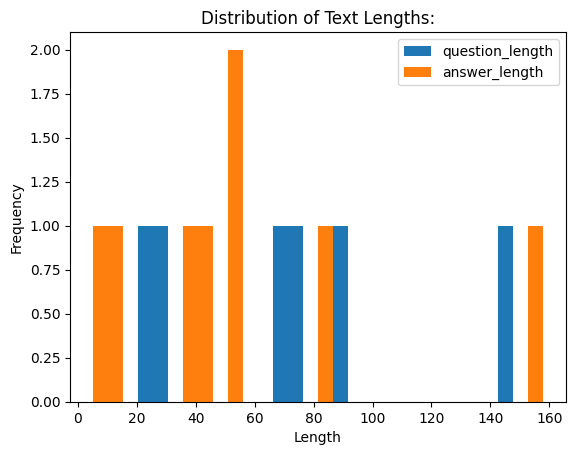

In [35]:
import matplotlib.pyplot as plt

# Calculate the length of each question and answer
df['question_length'] = df['question'].apply(len)
df['answer_length'] = df['answer'].apply(len)

df[['question_length', 'answer_length']].describe().plot(kind='hist', bins=30)
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title("Distribution of Text Lengths:")



In [36]:
#Most common words
from collections import Counter
import nltk
nltk.download('punkt')

def get_most_common_words(text_series):
    words = text_series.str.split().explode()
    common_words = Counter(words).most_common(20)
    return common_words

question_common_words = get_most_common_words(df['question'])
answer_common_words = get_most_common_words(df['answer'])


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Text(0.5, 0, 'Word')

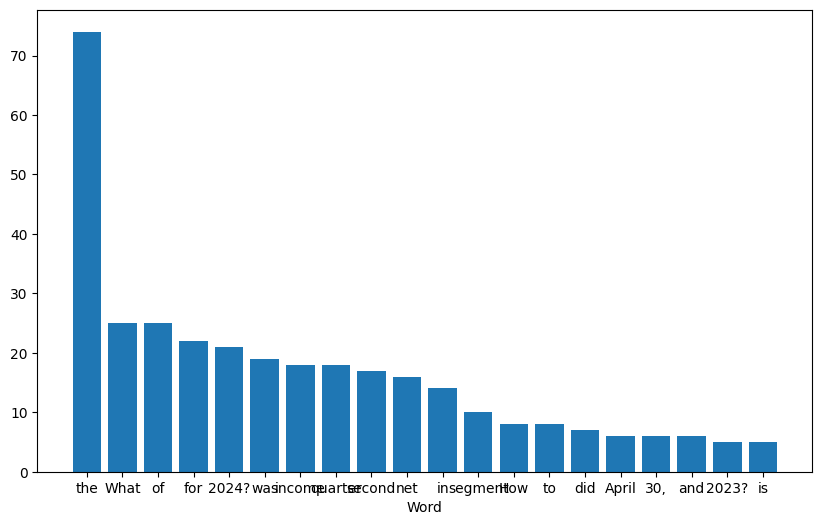

In [37]:
#print the most common words
plt.figure(figsize=(10, 6))
plt.bar([word[0] for word in question_common_words], [word[1] for word in question_common_words])
plt.xlabel('Word')


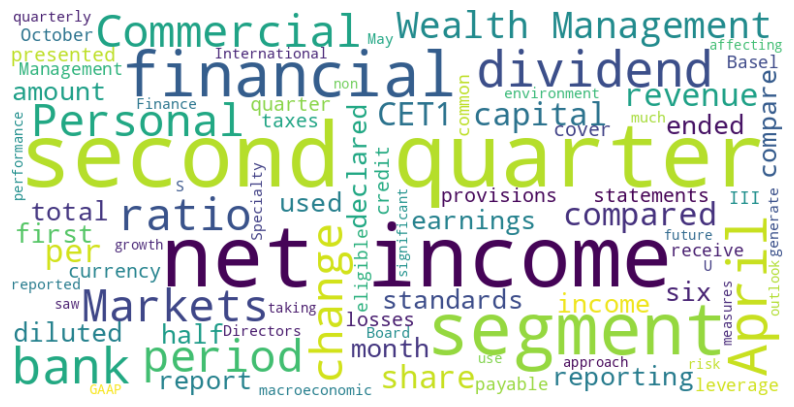

In [38]:
# word cloud of it

from wordcloud import WordCloud

# Join all questions into a single string
all_questions_text = ' '.join(df['question'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_questions_text)

# Display the generated image
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


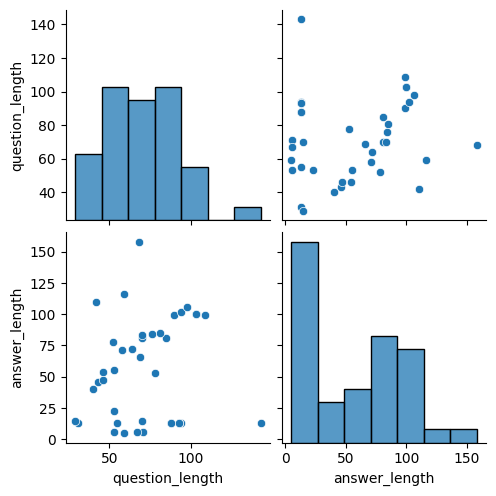

In [39]:
import seaborn as sns

sns.pairplot(df[['question_length', 'answer_length']])


<Axes: xlabel='labels', ylabel='count'>

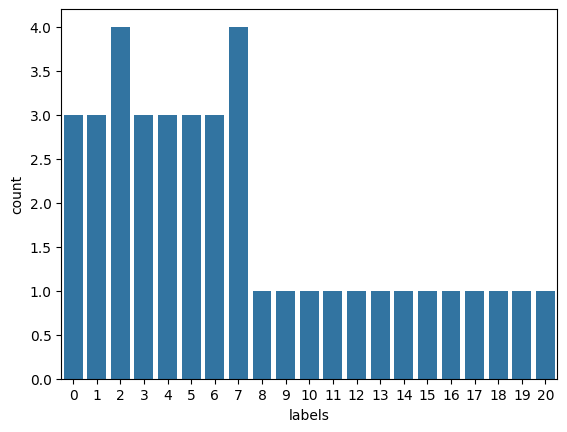

In [41]:
#Checking for Class Imbalance
import seaborn as sns

sns.countplot(x='labels', data=df)


In [3]:
#get all the unique tags to feed our pretrained model
labels = df['context'].unique().tolist()
#remove any whitespace left or right
labels = [s.strip() for s in labels]
labels

['The financial information reported in this document is based on the unaudited interim condensed consolidated financial statements for the quarter and six-month period ended April 30, 2024 and is prepared in accordance with International Financial Reporting Standards (IFRS) as issued by the International Accounting Standards Board (IASB), unless otherwise indicated. IFRS represent Canadian generally accepted accounting principles (GAAP). All amounts are presented in Canadian dollars.',
 'For the second quarter of 2024, National Bank is reporting net income of $906 million, up 9% from $832 million in the second quarter of 2023. Second-quarter diluted earnings per share stood at $2.54 compared to $2.34 in the second quarter of 2023. These increases were driven by total revenue growth in all of the business segments, partly offset by higher non-interest expenses and higher provisions for credit losses.',
 'For the six-month period ended April 30, 2024, the Bank’s net income totaled $1,82

In [4]:
#create our id to labels and labels to id, for the bert pre-trained model
num_labels = len(labels)
id2label = {id:label for id, label in enumerate(labels)}
label2id = {label:id for id, label in enumerate(labels)}

In [5]:
#label lenghts
len(label2id)

21

In [6]:
#add labels to df
df['labels'] = df['context'].map(lambda x: label2id[x.strip()])
df.head()

,context,question,answer,labels
0,The financial information reported in this doc...,What financial reporting standards were used i...,International Financial Reporting Standards (I...,0
1,The financial information reported in this doc...,What period do the financial statements cover?,The quarter and six-month period ended April 3...,0
2,The financial information reported in this doc...,In what currency are the amounts presented?,All amounts are presented in Canadian dollars.,0
3,"For the second quarter of 2024, National Bank ...",What was the net income for the second quarter...,$906 million.,1
4,"For the second quarter of 2024, National Bank ...",How did the net income for the second quarter ...,Net income increased by 9% from $832 million i...,1


In [7]:
# Extract the 'question' column from the DataFrame and convert it to a list
X = list(df['question'])

# Display the first 5 elements of the list
X[:5]


['What financial reporting standards were used in the report?',
 'What period do the financial statements cover?',
 'In what currency are the amounts presented?',
 'What was the net income for the second quarter of 2024?',
 'How did the net income for the second quarter of 2024 compare to the same quarter in 2023?']

In [8]:
# Extract the 'labels' column from the DataFrame and convert it to a list
y = list(df['labels'])

# Display the first 5 elements of the list
y[:5]


[0, 0, 0, 1, 1]

In [9]:
# Importing the train_test_split function from scikit-learn for splitting data into training and testing sets
from sklearn.model_selection import train_test_split

# Splitting the data into training and testing sets with a fixed random state for reproducibility
# X: List of questions (features)
# y: List of labels (targets)
# random_state=123: Seed for random number generator to ensure the split is reproducible
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)


In [10]:
# Importing PyTorch for tensor operations and neural network functionality
import torch

# Importing Dataset class from PyTorch for creating custom datasets
from torch.utils.data import Dataset

# Importing pipeline from transformers for easy access to pre-trained models and tokenizers
from transformers import pipeline

# Importing BertForSequenceClassification for sequence classification tasks using BERT
from transformers import BertForSequenceClassification, BertTokenizerFast

# Importing BertTokenizer for tokenizing text data for BERT models
from transformers import BertTokenizer

# Importing TrainingArguments and Trainer for training and evaluating models with transformers
from transformers import TrainingArguments, Trainer


In [11]:
# Masked language modeling (MLM): taking a sentence, the model randomly masks 15% of the words in the input then run the entire masked sentence through the model and has to predict the masked words. This is different from traditional recurrent neural networks (RNNs) that usually see the words one after the other, or from autoregressive models like GPT which internally masks the future tokens. It allows the model to learn a bidirectional representation of the sentence.
# Next sentence prediction (NSP): the models concatenates two masked sentences as inputs during pretraining. Sometimes they correspond to sentences that were next to each other in the original text, sometimes not. The model then has to predict if the two sentences were following each other or not.

model_name = "bert-base-uncased"
max_len = 256

#create the tokenizer with a max lenght of 256, if any text in our pattern is bigger, it will be truncated
tokenizer = BertTokenizer.from_pretrained(model_name,
                                          max_length=max_len)

#bert-large-uncased - it has 30k words variation
#leng of labels or tag we have, labels in format label to id and id to label
model = BertForSequenceClassification.from_pretrained(model_name,
                                                      num_labels=num_labels,
                                                      id2label=id2label,
                                                      label2id = label2id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
#tokenize X train and test
train_encoding = tokenizer(X_train, truncation=True, padding=True)
test_encoding = tokenizer(X_test, truncation=True, padding=True)

In [13]:
#tokenize X
full_data = tokenizer(X, truncation=True, padding=True)

In [14]:
# Importing Dataset class from PyTorch for creating a custom dataset
from torch.utils.data import Dataset
import torch

# Custom dataset class for handling BERT inputs and labels
class DataLoader(Dataset):

    def __init__(self, encodings, labels):
        """
        Initialize the dataset with encodings and labels.

        Args:
        - encodings (dict): A dictionary where keys are input feature names (e.g., 'input_ids', 'attention_mask')
                            and values are lists or arrays of encoded features.
        - labels (list): A list or array of labels corresponding to the encodings.
        """
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        """
        Retrieve an item from the dataset by index.

        Args:
        - idx (int): Index of the item to retrieve.

        Returns:
        - item (dict): A dictionary containing input features and label for the given index.
                       The dictionary keys are 'input_ids', 'attention_mask', etc., and 'labels'.
        """
        # Convert encoded features and labels to PyTorch tensors
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        """
        Get the total number of items in the dataset.

        Returns:
        - int: Number of items in the dataset.
        """
        return len(self.labels)


In [15]:
#get the data loader from pytorch for train and test
train_dataloader = DataLoader(train_encoding, y_train)
test_dataloader = DataLoader(test_encoding, y_test)

In [16]:
#get data loader for the full_data
fullDataLoader = DataLoader(full_data, y_test)

In [17]:
#parameters for out model to train
training_args = TrainingArguments(
    output_dir='./output',
    do_train=True,
    do_eval=True,
    num_train_epochs=100,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.05,
    logging_strategy='steps',
    logging_dir='./multi-class-logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    load_best_model_at_end=True
)



/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [18]:
# once the predictions are ready, we have coupled all the metrics together, so it can be futher utilize and added
# in a df
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def computeMetrics(pred):

    #get labels from predciton
    labels = pred.label_ids
    #get each pred
    predictions = pred.predictions.argmax(-1)
    #using sklearn.metrics set of metrics
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='macro')
    acc = accuracy_score(labels, predictions)

    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

In [19]:

#create a instance of the trainer, add model(bert with our labels ), training parameters, our data loaders,
#test dataset, and function with metrics to measure
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=test_dataloader,
    compute_metrics= computeMetrics
)

In [20]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,2.679000,2.230918,0.600000,0.518519,0.500000,0.555556
100,1.127600,1.104955,0.800000,0.629630,0.611111,0.666667


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

TrainOutput(global_step=100, training_loss=1.9033117294311523, metrics={'train_runtime': 27.4346, 'train_samples_per_second': 105.706, 'train_steps_per_second': 3.645, 'total_flos': 35772760641600.0, 'train_loss': 1.9033117294311523, 'epoch': 100.0})

In [21]:
#evaluation result
#add our evaluation results to dataset
evaluationResults=[trainer.evaluate(eval_dataset=mentalHealthDF) for mentalHealthDF in [train_dataloader, test_dataloader]]

pd.DataFrame(evaluationResults, index=["train","test"]).iloc[:,:5]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.334266,0.931034,0.873333,0.858333,0.900000
test,1.104955,0.800000,0.629630,0.611111,0.666667


In [22]:
#test of precition

#method that receives a text and base on the model(bert) will return a set of outputs, where we have included
# the probability of each response to check how accurate is

def predict(text):
    # Determine the appropriate device
    device = "cuda" if torch.cuda.is_available() else "cpu"
     # Tokenize the input text and move to the appropriate device (MPS or CPU)
    inputs = tokenizer(text, padding=True, truncation=True, max_length=max_len, return_tensors="pt").to(device)

    #send input to model
    outputs = model(**inputs)

    #get probability of response
    probs = outputs[0].softmax(1)
    #get ID label predicted
    pred_label_idx = probs.argmax()
     #get label predicted
    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label

In [23]:
#simple test with a hello to see our results
text = "GAAP measures"
predict(text)

(tensor([[0.1009, 0.0148, 0.0301, 0.0936, 0.0117, 0.0093, 0.0828, 0.0776, 0.0275,
          0.0664, 0.0642, 0.0096, 0.0057, 0.0166, 0.0325, 0.1315, 0.0149, 0.0167,
          0.0788, 0.0298, 0.0851]], device='cuda:0', grad_fn=<SoftmaxBackward0>),
 tensor(15, device='cuda:0'),
 'Dividends: On May 28, 2024, the Board of Directors declared regular dividends on the various series of first preferred shares and a dividend of $1.10 per common share, up 4 cents or 4%, payable on August 1, 2024, to shareholders of record on June 24, 2024.')

In [24]:
import torch
import math

def calculate_perplexity(text, model, tokenizer, max_len=512):
    # Determine the appropriate device
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Tokenize the input text and move to the appropriate device
    inputs = tokenizer(text, padding=True, truncation=True, max_length=max_len, return_tensors="pt").to(device)

    # Forward pass through the model to get the logits
    with torch.no_grad():
        outputs = model(**inputs) # Remove the labels argument here
        logits = outputs.logits

    # Compute the loss using the CrossEntropy loss function
    shift_logits = logits[..., :-1, :].contiguous()
    shift_labels = inputs['input_ids'][..., 1:].contiguous()

    # Check if shift_logits is empty and handle the case
    if shift_logits.size(0) == 0:
        print("Warning: No valid tokens generated. Returning perplexity as infinity.")
        return float('inf')

    loss_fct = torch.nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id, reduction='none')
    loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))

    # Compute the average loss
    avg_loss = loss.sum().item() / len(text.split())

    # Calculate perplexity
    perplexity = math.exp(avg_loss)

    return perplexity

# Example usage:
perplexity = calculate_perplexity(" ", model, tokenizer)
print(f"Perplexity: {perplexity}")

Perplexity: inf


In [25]:
!pip install evaluate

In [26]:
# Calculating Belu Score

import evaluate

# Load the accuracy metric from the Hugging Face evaluate library
accuracy_metric = evaluate.load("accuracy")

# Get predictions for the test dataset
predictions = trainer.predict(test_dataloader)

# Extract predicted labels and true labels
predicted_labels = predictions.predictions.argmax(-1)
true_labels = predictions.label_ids

# Calculate accuracy
accuracy = accuracy_metric.compute(predictions=predicted_labels, references=true_labels)

# Print the accuracy score
print(f"Accuracy: {accuracy['accuracy']}")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.8


In [28]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=a31299f83573d8840d52440986e301a324e4fcf84ede2f784d790a9d381e9639
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [29]:


# Calculating ROUGE Score

# Load the ROUGE metric from the Hugging Face evaluate library
rouge_metric = evaluate.load('rouge')

# Assuming you have the ground truth summaries and generated summaries in lists
# Replace these with your actual data
ground_truth_summaries = ["This is a ground truth summary."]
generated_summaries = ["This is a generated summary."]

# Calculate ROUGE scores
rouge_scores = rouge_metric.compute(predictions=generated_summaries, references=ground_truth_summaries)

# Print ROUGE scores
print(rouge_scores)


{'rouge1': 0.7272727272727272, 'rouge2': 0.4444444444444445, 'rougeL': 0.7272727272727272, 'rougeLsum': 0.7272727272727272}


In [ ]:
#indicate the path to save our model
model_path = "chatbot"
#save model and pretrained model
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('chatbot\\tokenizer_config.json',
 'chatbot\\special_tokens_map.json',
 'chatbot\\vocab.txt',
 'chatbot\\added_tokens.json')

In [ ]:
#path to retreive trained files
model_path = "chatbot"

#get model
model = BertForSequenceClassification.from_pretrained(model_path)
#get tokes
tokenizer= BertTokenizerFast.from_pretrained(model_path)

#send pretrained and saved model and tokenization, device =cpu, since is mac and we dont have gpu
chatbot= pipeline(task="text-classification", model=model, tokenizer=tokenizer, function_to_apply="softmax")


C:\Users\Saugat\anaconda3\Lib\site-packages\transformers\modeling_utils.py:479: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location

In [ ]:
chatbot.model.save_pretrained(model_path)

In [ ]:
chatbot("What was the net income for the second quarter of 2024?")

[{'label': 'For the second quarter of 2024, National Bank is reporting net income of $906 million, up 9% from $832 million in the second quarter of 2023. Second-quarter diluted earnings per share stood at $2.54 compared to $2.34 in the second quarter of 2023. These increases were driven by total revenue growth in all of the business segments, partly offset by higher non-interest expenses and higher provisions for credit losses.',
  'score': 0.7333829998970032}]

In [ ]:
# Reading JSON Data and store in a dictionary
def read_json_as_dict(file_path):
    # Read the JSON data from the file and load it into a Python dictionary
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

data = read_json_as_dict('traindata.json')
data[0]

{'context': 'The financial information reported in this document is based on the unaudited interim condensed consolidated financial statements for the quarter and six-month period ended April 30, 2024 and is prepared in accordance with International Financial Reporting Standards (IFRS) as issued by the International Accounting Standards Board (IASB), unless otherwise indicated. IFRS represent Canadian generally accepted accounting principles (GAAP). All amounts are presented in Canadian dollars.',
 'qas': [{'question': 'What financial reporting standards were used in the report?',
   'answer': 'International Financial Reporting Standards (IFRS) as issued by the International Accounting Standards Board (IASB).'},
  {'question': 'What period do the financial statements cover?',
   'answer': 'The quarter and six-month period ended April 30, 2024.'},
  {'question': 'In what currency are the amounts presented?',
   'answer': 'All amounts are presented in Canadian dollars.'}]}

In [ ]:
def get_random_answer(data, context_value):
    for item in data:
        if item['context'] == context_value:
            return random.choice(item['qas'])['answer']
    return "Sorry, I could not answer you. Try different prompt"

In [ ]:
import random
#create a simple program to test the chatbot
def chat(chatbot):

    print("NationalBert: Hello, I'm NationalBert. how do you want to know about the quarterly report of National Bank")
    print("Type 'quit' to exit the chat\n\n")

    #get user input
    userInput = input("User: ").strip().lower()

    #while user requires to stay in the chat
    while(userInput != 'quit'):

        #send user input to chatbot (pipeline with our model and tokens)
        #get score
        score = chatbot(userInput)[0]['score']

        #if score is less than 80% we do not return an aswer
        if score < 0.5:
            print("NationalBert: Sorry, I can not understand you, try with different prompt..\n\n")
            #ask for user input
            userInput = input("User: ").strip().lower()
            continue

        #get our lavel response
        label = chatbot(userInput)[0]['label']
        answers = get_random_answer(data, label)
        #get response
        response = answers

        #show our score, label and response
        print(f"NationalBert: score {score}\n, context: {label}\n, response:  {response}\n\n")


        #get user input
        userInput = input("User: ").strip().lower()



In [ ]:
chat(chatbot)

NationalBert: Hello, I'm NationalBert. how do you want to know about the quarterly report of National Bank
Type 'quit' to exit the chat


User: What financial reporting standards are used in the quarterly report?
NationalBert: score 0.6991391181945801
, context: The financial information reported in this document is based on the unaudited interim condensed consolidated financial statements for the quarter and six-month period ended April 30, 2024, and is prepared in accordance with International Financial Reporting Standards (IFRS) as issued by the International Accounting Standards Board (IASB), unless otherwise indicated. IFRS represent Canadian generally accepted accounting principles (GAAP). All amounts are presented in Canadian dollars.
, response:  The report is prepared in accordance with International Financial Reporting Standards (IFRS) as issued by the International Accounting Standards Board (IASB).


User: quit
